# Programming K-means (the unsupervised clustering algorithm) in Spark

Algorithm k-means (k)	
1. Initialize the location of the k prototypes kj
	 (usually, randomly)	
2. (MAP) Assign each instance xi to its closest prototype 
	(usually, closeness = Euclidean distance).	
3. (REDUCE) Update the location of prototypes kj as the average of the instances xi assigned to each cluster.	
4. Go to 2, until 	clusters do not change


**Start the SPARK context**

In [2]:
import sys
import os
import os.path

SPARK_HOME = """C:/spark-2.1.0-bin-hadoop2.7""" #CHANGE THIS PATH TO YOURS!

sys.path.append(os.path.join(SPARK_HOME, "python", "lib", "py4j-0.10.4-src.zip")) #BEWARE WITH py4j version!!
sys.path.append(os.path.join(SPARK_HOME, "python", "lib", "pyspark.zip"))
os.environ["SPARK_HOME"] = SPARK_HOME


from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("kmeans") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
    
sc = spark.sparkContext

**Check the SPARK context there  **

In [3]:
print(sc)
print(type(sc))

<class 'pyspark.context.SparkContext'>


**Relevant packages are loaded**

In [4]:
%matplotlib inline
from pyspark.mllib.regression import LabeledPoint
import numpy as np
import matplotlib.pyplot as plt

**The iris dataset is loaded in the driver program **

In [5]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data            # Input attributes
y = iris.target          # Label
# zip is used so that each instance is a tuble of (label, input attributes). 
# This will make life easier later
# Note: zip([1,2,3], ["a","b","c"]) => [(1, 'a'), (2, 'b'), (3, 'c')]
data = zip(y,X) 

**And then, it is distributed into 4 partitions (or the numbers of actual cores in your computer)**

In [6]:
data_rdd = sc.parallelize(data,4)
print data_rdd.getNumPartitions()

4


** Now, each instance is transformed into a spark labeled point. k-means could be programmed using only standard RDDs, without using LabeledPoints, but we will use them in order to handle all datasets in the same way. **

In [7]:
data_rdd = data_rdd.map(lambda x: LabeledPoint(x[0], x[1]))
data_rdd.take(1)

[LabeledPoint(0.0, [5.1,3.5,1.4,0.2])]

**Now we separate input attributes (X_rdd) from labels (y_rdd). In order to program K-Means, only X_rdd will be used, because K-means is an unsupervised algorithm **

In [8]:
X_rdd = data_rdd.map(lambda x: x.features)
y_rdd = data_rdd.map(lambda x: x.label)

In [9]:
print(X_rdd.take(2))
print(y_rdd.take(2))

[DenseVector([5.1, 3.5, 1.4, 0.2]), DenseVector([4.9, 3.0, 1.4, 0.2])]
[0.0, 0.0]


** The K-means algorithm starts here. First, the number of required clusters is initialized to 3 and the initial prototypes are initialized to three random instances (the original algorithm initialized it to three random locations)**

In [10]:
K=3
kPrototypes = X_rdd.takeSample(False, K, 1)
kPrototypes

[DenseVector([6.4, 2.8, 5.6, 2.2]),
 DenseVector([5.5, 2.5, 4.0, 1.3]),
 DenseVector([5.2, 4.1, 1.5, 0.1])]

**The following function is not part of the K-means algorithm but it will help us to plot iris data and the current location of the three prototypes. Remark: iris has four input attributes and therefore prototypes have also four-dimensional. For the sake of simplicity, the plot shows only the first two input attributes.  **

In [11]:
def plotPrototypes():
    plt.scatter(X[:, 0], X[:, 1])
    # kPrototypes is transformed into a numpy matrix (attributes in the columns, instances in the rows)
    kProtos = np.array(map(lambda x: x, np.array(kPrototypes)))
    plt.scatter(kProtos[:,0], kProtos[:,1], color='red', s=200)

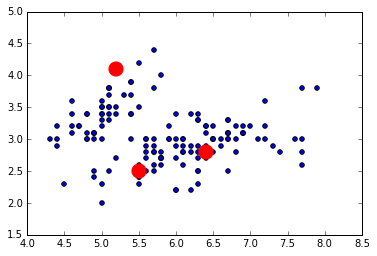

In [12]:
plotPrototypes()

**Step 2 of the K-means algorithm is "2.Assign each instance xi to its closest prototype". Function closestPrototype is defined for this purpose** 

In [13]:
def closestPrototype(x):
    # First, 
    distances = map(lambda kp: np.linalg.norm(x-kp), kPrototypes)
    distances = np.array(distances)
    return(np.ndarray.argmin(distances))


**Step 2.Assign each instance xi to its closest prototype.** 
  closest_rdd is an RDD that contains a (key, value) tuple. The key is the index (0,1,2) of the closest of the three prototypes. The value is (x,1). x are the input attributes *x* of the instance. The "1" is difficult to understand at this point, but it will be useful later.

In [14]:
closest_rdd = X_rdd.map(lambda x: (closestPrototype(x), (x,1)))

In [15]:
closest_rdd.takeSample(False, 10, 1)

[(2, (DenseVector([5.1, 3.5, 1.4, 0.3]), 1)),
 (2, (DenseVector([5.0, 3.0, 1.6, 0.2]), 1)),
 (1, (DenseVector([6.1, 2.8, 4.7, 1.2]), 1)),
 (0, (DenseVector([6.3, 2.5, 5.0, 1.9]), 1)),
 (0, (DenseVector([7.4, 2.8, 6.1, 1.9]), 1)),
 (2, (DenseVector([4.7, 3.2, 1.6, 0.2]), 1)),
 (0, (DenseVector([6.3, 2.9, 5.6, 1.8]), 1)),
 (2, (DenseVector([4.6, 3.4, 1.4, 0.3]), 1)),
 (0, (DenseVector([6.8, 3.0, 5.5, 2.1]), 1)),
 (1, (DenseVector([5.5, 2.5, 4.0, 1.3]), 1))]

**Step 3.(REDUCE) Update the location of prototypes kj as the average of the instances xi assigned to each cluster. **: 

In [16]:
# For every prototype, compute the sum of the input attributes of the instances assigned to each prototype: p1[0] + p2[0]
# The aim is to eventually compute the average, which is this sum divided by the number of instances assigned to each prototype
# In order to compute the number of instances of each prototype, we add the "1"s: p1[1] + p2[1]
# Notice that kPrototypes is a variable collected in the (local) driver program
kPrototypes = closest_rdd.reduceByKey(lambda p1, p2: (p1[0] + p2[0], p1[1] + p2[1])).collect()
kPrototypes


[(0, (DenseVector([383.1, 173.1, 316.7, 113.6]), 58)),
 (1, (DenseVector([243.1, 114.1, 173.9, 54.0]), 42)),
 (2, (DenseVector([250.3, 170.9, 73.2, 12.2]), 50))]

In [17]:
# The average is now computed locally (in the driver program)

kPrototypes = map(lambda (k,(summation, n)): summation / n, kPrototypes)
kPrototypes

[DenseVector([6.6052, 2.9845, 5.4603, 1.9586]),
 DenseVector([5.7881, 2.7167, 4.1405, 1.2857]),
 DenseVector([5.006, 3.418, 1.464, 0.244])]

**Let's see if the prototypes have a better location now **

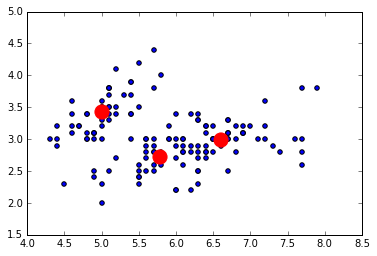

In [18]:
plotPrototypes()

**The K-means steps are carried out 4 times more (actually, they should be carried out until the prototypes remain approximately in the same place)**

In [19]:
for i in range(4):
    # 2. (MAP) Assign each instance xi to its closest prototype 
    closest_rdd = X_rdd.map(lambda x: (closestPrototype(x), (x,1)))
    # 3. (REDUCE) Update the location of prototypes kj as the average of the instances xi assigned to each cluster.
    kPrototypes = closest_rdd.reduceByKey(lambda p1, p2: (p1[0] + p2[0], p1[1] + p2[1])).collect()
    kPrototypes = map(lambda (k,(summation, n)): summation / n, kPrototypes)

In [20]:
kPrototypes

[DenseVector([6.8023, 3.0442, 5.6488, 2.0302]),
 DenseVector([5.8544, 2.7421, 4.3456, 1.4088]),
 DenseVector([5.006, 3.418, 1.464, 0.244])]

** And check the final result **

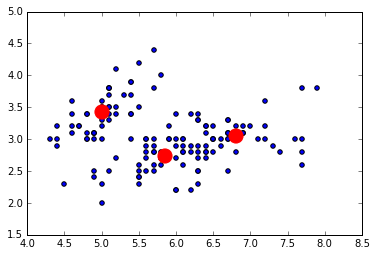

In [21]:
plotPrototypes()

In [22]:
# Finally, the spark context is closed
sc.stop()